In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt

from astropy import units as u
from astropy.coordinates import SkyCoord

from easycat.download import WISEDataArchive
from easycat.lightcurve.plot import plot_wiselc, plot_positions
from easycat.lightcurve.reprocess import ReprocessFactory

## Downloading WISE Lightcurve

In [2]:
# position of target
pos_ref = SkyCoord(ra=153.38352, dec=26.47322, unit="deg", frame="fk5")

# instantiate a downloader
arch = WISEDataArchive()

# retrieve WISE photometric data from IRSA
is_successful, lcurve = arch.retrieve_photo_for_item(
    item_id="test_obj",
    coord=pos_ref,
    radius=6*u.arcsec, # <-- matching radius
    return_data=True
)

print("Is successful?", is_successful)

Is successful? True


In [3]:
print(type(lcurve)) # a pandas DataFrame
print(lcurve.columns)

<class 'pandas.core.frame.DataFrame'>
Index(['raj2000', 'dej2000', 'mjd', 'w1mag', 'w1sigmag', 'w1rchi2', 'w2mag',
       'w2sigmag', 'w2rchi2', 'na', 'nb', 'qi_fact', 'cc_flags', 'saa_sep',
       'moon_masked', 'qual_frame'],
      dtype='object')


## Reprocessing WISE Data

In [4]:
# Firstly, we need to get a WISE Reprocessor from Reprocess Factory
repro = ReprocessFactory.get(metadata={
    "telescope": "WISE"
})

# Our default pipeline:
# 1. Sort data by MJD
# 2. Filter missing data
# 3. criteria_basic
# 4. DBSCAN
# 5. filter outliers
lcurve_repro = repro.reprocess(lcurve=lcurve, pos_ref=pos_ref)

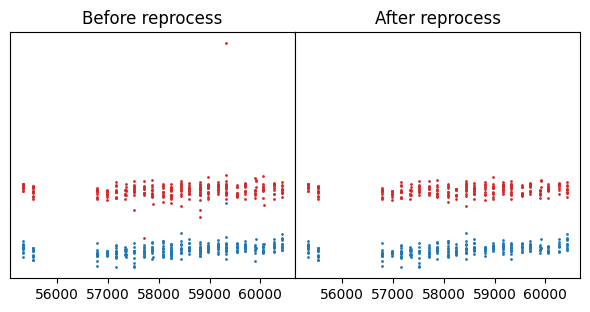

In [5]:
fig, axs = plt.subplots(1, 2, sharey=True, sharex=True, figsize=(6, 3))

axs[0].scatter(lcurve.mjd, lcurve.w1mag, c="tab:blue", s=1)
axs[0].scatter(lcurve.mjd, lcurve.w2mag, c="tab:red",  s=1)
axs[0].yaxis.set_inverted(True)

axs[1].scatter(lcurve_repro.mjd, lcurve_repro.w1mag, c="tab:blue", s=1)
axs[1].scatter(lcurve_repro.mjd, lcurve_repro.w2mag, c="tab:red",  s=1)
axs[1].set_yticks([])

fig.tight_layout(w_pad=0)

axs[0].set_title("Before reprocess")
axs[1].set_title("After reprocess")
plt.show()

### Why DBSCAN?
A large matching radius risks blending photometric data from multiple sources, but clustering algorithms can mitigate this effect.

In [6]:
pos_ref = SkyCoord(ra=182.1992, dec=67.3094, unit="deg", frame="fk5")

arch = WISEDataArchive()

is_successful, lcurve = arch.retrieve_photo_for_item(
    item_id="test_obj",
    coord=pos_ref,
    radius=6*u.arcsec,
    return_data=True
)

lcurve_repro = repro.reprocess(lcurve=lcurve, pos_ref=pos_ref)

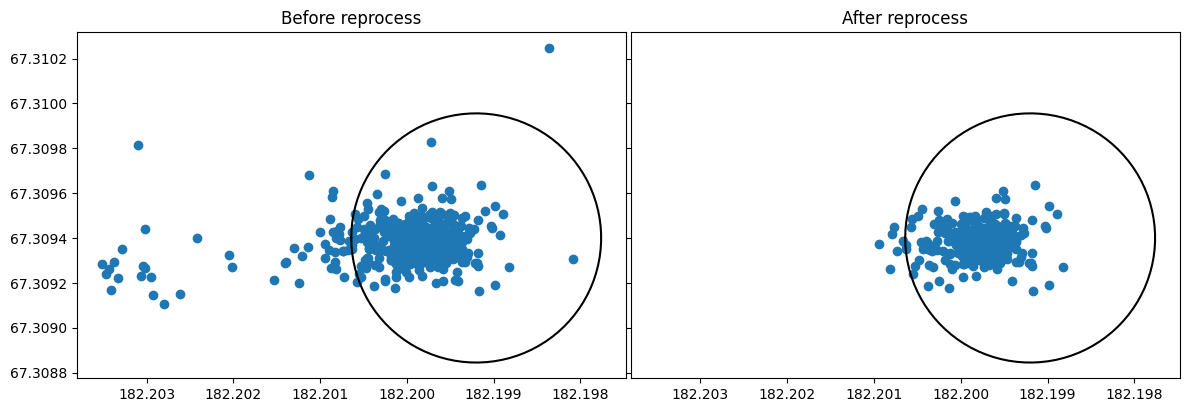

In [7]:
wise_pos = SkyCoord(ra=lcurve["raj2000"], dec=lcurve["dej2000"], unit="deg", frame="fk5")
wise_pos_repro = SkyCoord(ra=lcurve_repro["raj2000"], dec=lcurve_repro["dej2000"], unit="deg", frame="fk5")

fig, axs = plt.subplots(1, 2, sharey=True, sharex=True, figsize=(12, 4))


plot_positions(axs[0], wise_pos, pos_ref)
plot_positions(axs[1], wise_pos_repro, pos_ref)

fig.tight_layout(w_pad=0)

axs[0].set_title("Before reprocess")
axs[1].set_title("After reprocess")

plt.show()

## Generating Long-term WISE Lightcurve

Then let us generate long-term WISE lightcurve,

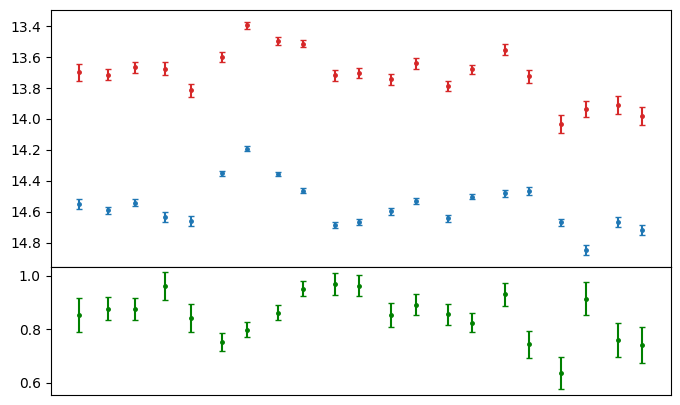

In [8]:
longterm = repro.generate_longterm_lcurve(lcurve_repro, max_interval=10)
fig = plot_wiselc(lcurve=longterm)
plt.show()

## More patterns to download

### Downloading a catalog

In [9]:
catalog = pd.DataFrame(data=[
    ("J150941.18+184601.0", 227.4216, 18.7669),
    ("J140034.70+004733.4", 210.1446, 0.7926),
    ("J120847.81+671833.8", 182.1992, 67.3094)
], columns=["obj_id", "raj2000", "dej2000"])
catalog.set_index(keys="obj_id", inplace=True)

**Tip**
You can create the `catalog` by reading from Excel Table or other local file. For example,
``` Python
catalog = pd.read_csv("test.csv")
catalog.rename(columns={
    "RA": "raj2000",
    "Dec": "dej2000"
}, inplace=True)
catalog.set_index(keys="Name", inplace=True)
```

In [10]:
store_dir = "./wisedata/"
checkpoint = "wisedata_checkpoint.pkl"
os.makedirs(store_dir, exist_ok=True)

arch = WISEDataArchive()

record = arch.retrieve_photo(
    catalog=catalog,
    radius=6*u.arcsec,

    store_dir=store_dir, # <-- store WISE data under store_dir
    return_data=False,
    n_works=10,
    checkpoint=checkpoint
)

if len(record.get("completed")) == len(catalog):
    os.remove(checkpoint)

Creating log file [wisedata_checkpoint.pkl] ... Completed.



Summary
Total: 3
Completed: 3
Failed: 0
Cancelled: 0


In [11]:
print("Completed Set:", record.get("completed"))
print("Failed Set:", record.get("failed"))

Completed Set: {'J120847.81+671833.8', 'J140034.70+004733.4', 'J150941.18+184601.0'}
Failed Set: set()


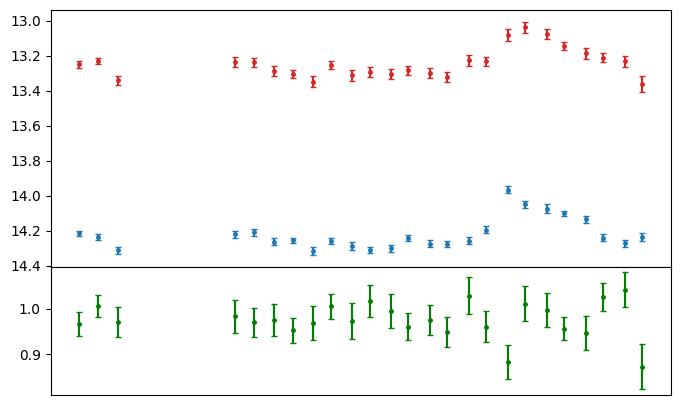

In [12]:
from astropy.table import Table
from astropy.io import fits

repro = ReprocessFactory.get(metadata={ "telescope": "WISE" })

idx = 0
row = catalog.iloc[idx]
obj_id = catalog.index[idx]
pos = SkyCoord(ra=row["raj2000"], dec=row["dej2000"], unit="deg", frame="fk5")

with fits.open(os.path.join(store_dir, obj_id+".fits")) as hdul:
    lcurve = Table(hdul[1].data).to_pandas()

lcurve_repro = repro.reprocess(lcurve=lcurve, pos_ref=pos)
longterm = repro.generate_longterm_lcurve(lcurve_repro, 10)

fig = plot_wiselc(longterm)